# House Prices Project

We want to predict the property's sale price in dollars, i.e. the target variable is 'SalePrice'.

Metric: Models are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

## Data Exploration

In [1]:
# First let us import the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # set plot styles
from scipy.stats import norm
from scipy.stats import lognorm
from scipy import stats
%matplotlib inline 
# to show the plots inline
#plt.style.use('seaborn-pastel') # Here we can choose the plotting style

In [2]:
# Let's read-in the training dataset
trainData = pd.read_csv('data/train.csv')

In [ ]:
## Important Notes!
# To make a copy of an array
#data_sub_copy = data[:2, :2].copy()

# When subsetting a pd Series use loc (explicit, row labels) and iloc (implicit, row index), 
# data.loc[1:3] or data.iloc[1], this explicitly tells us what indexing system we are using and removes ambiguity.
# This makes the code easy to read and understand

# For DF
# Use data['pop'] = z rather than data.pop = z, this avoids potential problems
# To add a new column: data['density'] = data['pop'] / data['area']
# data.values gives array of values only
# For array-style indexing use the loc, iloc, and ix indexers
# With the iloc indexer we can index the underlying array as if it is a simple NumPy array:
# data.iloc[:3, :2] but this keeps the col and row labels
# or use explicit lables: data.loc[:'Illinois', :'pop']
# The ix indexer allows a hybrid of these two approaches: data.ix[:3, :'pop']
# Fancy indexing: data.loc[data.density > 100, ['pop', 'density']]
# this picks out rows with density>100, and shows only two cols pop and density
# Set a new value in a particular position: data.iloc[0, 2] = 90
# Remamber: indexing refers to columns, slicing refers to rows
# data['Florida':'Illinois'] or data[1:3] slices rows
# Direct masking operations are also row-wise: data[data.density > 100] returns rows with cond

In [3]:
# We can take a quick look at the size of the dataset
[trainData.size, # total number of elements
trainData.ndim, # number of dimentions
trainData.shape[0], # number of rows
trainData.shape[1], # number of columns
trainData.shape] 

[118260, 2, 1460, 81, (1460, 81)]

In [4]:
# To look at the variable names. Here the first 5.
trainData.columns[:5]

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea'], dtype='object')

In [57]:
# Here I want to check the variable types and summarise
#trainData['Id'].dtype # checks just one var
trainData.dtypes # checks all vars
trainData.dtypes.value_counts() # count the number of types
# Hence there are 38 numerical variables (int and floats) and 43 categorical variables. Of course some of these 
# numerical variables could actually be categorical. This is something to check.

object     43
int64      35
float64     3
dtype: int64

In [7]:
# Here we can take a quick look at the data
# trainData.head(3) # first 3 rows
# df.describe() # to summarise the whole data frame
# df.describe(include=['O']) # to summarise all the character variables
# df.describe(include=['float64']) # for the numeric values
# df['productcode'].value_counts() # frequency of categorical var
trainData['SaleType'].value_counts() # as an example

WD       1267
New       122
COD        43
ConLD       9
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

### The target variable
Now we look into the target variable in more detail. We can see at first that there is no weird data such as House Prices at 0 value.

In [71]:
# Summary statistics for the target variable
trainData['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [5]:
# What's the variance of our target variable:
trainData['SalePrice'].var()
# Totally different to the mean, by many orders of magnitude, hence this is not a Poisson distribution

6311111264.2974482

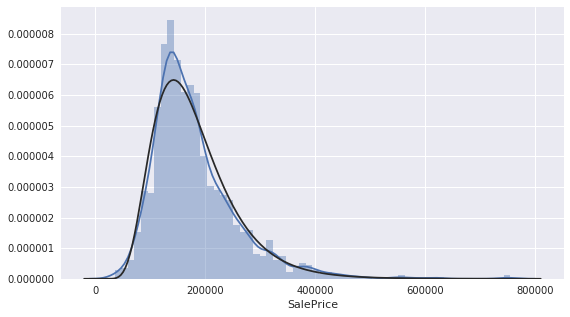

In [3]:
# Let's look at the distribution of the target variable
plt.subplots(figsize=(9, 5))
sns.distplot(trainData['SalePrice'], bins= 60, fit=lognorm); # fits a LogNormal distribution quite well

In [4]:
## IMPORTANT!
# Here we are applying a log transformation to the target variable
trainData['SalePrice'] = np.log(trainData['SalePrice'])
trainData.shape

(1460, 81)

The models are to be evaluated on the log of the SalePrice.

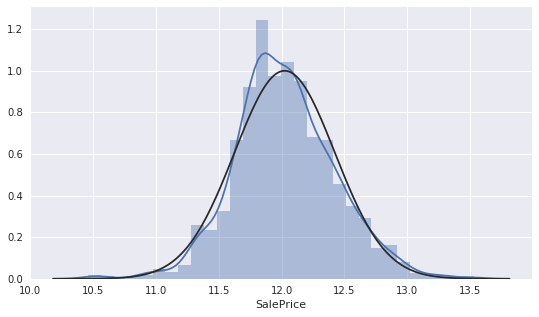

In [6]:
# Let's look at the distribution of the new target variable
plt.subplots(figsize=(9, 5))
sns.distplot(trainData['SalePrice'], bins= 30, fit=norm); # fits a Normal distribution quite well

Linear models are based on the assumption that the target variable/random error is Normally distributed. We should check this point, I thought Generalised-Linear models relaxed this assumption. Anyway, I think this affects things when you want to do statistics e.g. hypothesis testing etc, but maybe not so important for predictions.

"Interpreting model parameters is much more a statistical modeling question than a machine learning question. Machine learning rather focuses on what the model predicts."

In [7]:
# Here we can check for skewness and kurtosis, since the distribution does not look Gaussian exactly
[trainData['SalePrice'].skew(), trainData['SalePrice'].kurt()]

[0.12133506220520406, 0.80953199580362956]

### Correlations

We can do a correlation matrix of all numerical variables. But honestly, I find that to be too much information in one plot and therefore not so useful. I find it best to look at a subset of variables which are most highly correlated with the target variable SalePrice.

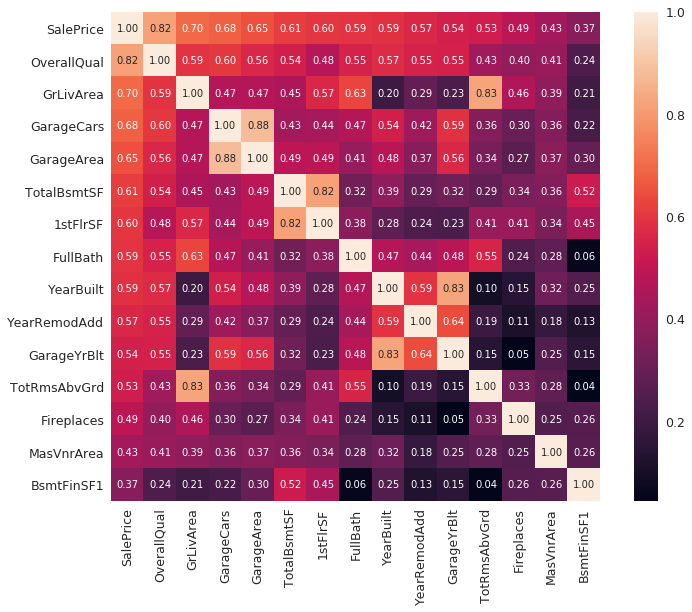

In [36]:
# This is the correlation matrix between all the numerical variables (floats and ints)
corrmatrix = trainData.corr()
#f, ax = 
# plt.subplots(figsize=(12, 9)) # this changes the plot size, but not sure why it's writen like that!
# sns.heatmap(corrmatrix, vmax=.8, square=True); # heatmap for full correlation matrix
#corrmatrix.shape
#corrmatrix.iloc[:3, :3] # look at first few elements
#corrmatrix['SalePrice']
#np.abs(corrmatrix.head(3))

# The correlation matrix for SalePrice 
# First we collect 15 columns with largest abs correlations with target variable SalePrice
# What we care about is the absolute value of the correlation, 
# we don't care about positive or negative relationships
cols15 = np.abs(corrmatrix).nlargest(15, 'SalePrice')['SalePrice'].index 
corrm15 = corrmatrix.loc[cols15, cols15].values # this picks out top 15 elements
sns.set(font_scale=1.25)
plt.subplots(figsize=(12, 9))
hm = sns.heatmap(corrm15, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 10}, yticklabels=cols15.values, xticklabels=cols15.values)
plt.show()


In this group of variables, excluding correlations with our target variable, we can identify highly correlated (> 0.8) pairs:
* GarageCars (Size of garage in car capacity) and GarageArea (Size of garage in square feet) 
* TotalBsmtSF (Total square feet of basement area) and 1stFlrSF (First Floor square feet) 
* GrLivArea (Above grade (ground) living area square feet) and TotRmsAbvGrd (Total rooms above grade (does not include bathrooms)) 
* YearBuilt (Original construction date) and GarageYrBlt (Year garage was built)

It comes to no supprise that these pairs are highly correlated, they essentially trace the same characteristics. In building our models we should keep these in mind and possibly not include all the paired variables in order to keep the variance low.

The top 4 numerical variables which correlate with SalePrice most strongly are:
* OverallQual: Overall material and finish quality
* GrLivArea/TotRmsAbvGrd: Above grade (ground) living area square feet/Total rooms above grade (does not include bathrooms)
* GarageCars/GarageArea: Size of garage in car capacity/Size of garage in square feet
* TotalBsmtSF/1stFlrSF: Total square feet of basement area/First Floor square feet, i.e. size of property

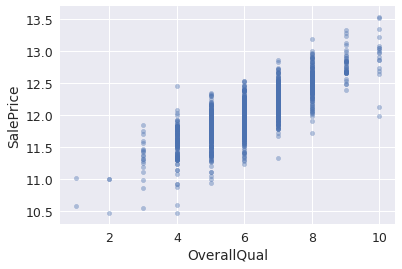

In [9]:
# Let's visualise the most important numerical correlations
trainData.plot.scatter(x='OverallQual', y='SalePrice', alpha=0.4);

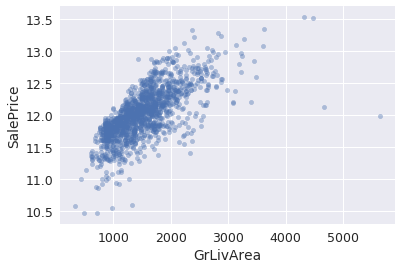

In [10]:
trainData.plot.scatter(x='GrLivArea', y='SalePrice', alpha=0.4);

So far we have only looked at the relationships between numerical variables. 

Note: Some numerical variables are integers and could be considered categorical. However these, such as OverallQual are ordered, hence can be used sensibly for correlations. Others are not, for example the variable Id makes no sense to use as correlator.

A big question comes up: how do we handle all these categorical variables. We could search for the variables which separates the data best, but this could take a lot of time. I think this is where automatic model selection comes into play.

In [4]:
# There are 43 categorical variables we have so far not looked into
trainData.dtypes.value_counts() # count the number of types

object     43
int64      35
float64     3
dtype: int64

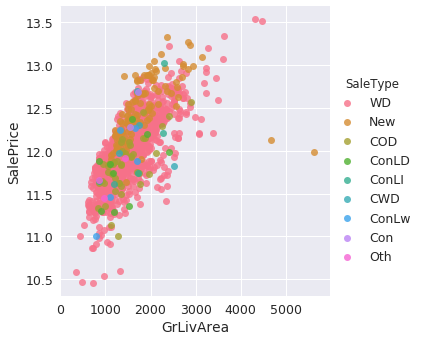

In [11]:
sns.lmplot(x='GrLivArea', y='SalePrice', data=trainData, hue='SaleType', fit_reg=False);
# this is a bit overplotted to my taste

In [28]:
sns.lmplot?

In [29]:
# Summary statistics for a categorical variable
trainData['SaleType'].describe()

count     1460
unique       9
top         WD
freq      1267
Name: SaleType, dtype: object

In [37]:
# Does it make more sense to use this variable as a categorical variable?
trainData['MSSubClass'].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

# Missing Values

In [38]:
# Check the number of missing values per column
for i in list(trainData.columns) :
    k = sum(pd.isnull(trainData[i]))
    print(i, k)

Id 0
MSSubClass 0
MSZoning 0
LotFrontage 259
LotArea 0
Street 0
Alley 1369
LotShape 0
LandContour 0
Utilities 0
LotConfig 0
LandSlope 0
Neighborhood 0
Condition1 0
Condition2 0
BldgType 0
HouseStyle 0
OverallQual 0
OverallCond 0
YearBuilt 0
YearRemodAdd 0
RoofStyle 0
RoofMatl 0
Exterior1st 0
Exterior2nd 0
MasVnrType 8
MasVnrArea 8
ExterQual 0
ExterCond 0
Foundation 0
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinSF1 0
BsmtFinType2 38
BsmtFinSF2 0
BsmtUnfSF 0
TotalBsmtSF 0
Heating 0
HeatingQC 0
CentralAir 0
Electrical 1
1stFlrSF 0
2ndFlrSF 0
LowQualFinSF 0
GrLivArea 0
BsmtFullBath 0
BsmtHalfBath 0
FullBath 0
HalfBath 0
BedroomAbvGr 0
KitchenAbvGr 0
KitchenQual 0
TotRmsAbvGrd 0
Functional 0
Fireplaces 0
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageCars 0
GarageArea 0
GarageQual 81
GarageCond 81
PavedDrive 0
WoodDeckSF 0
OpenPorchSF 0
EnclosedPorch 0
3SsnPorch 0
ScreenPorch 0
PoolArea 0
PoolQC 1453
Fence 1179
MiscFeature 1406
MiscVal 0
MoSold 0
YrSol

# The test dataset

In [5]:
# Let's read-in the testing dataset
testData = pd.read_csv('data/test.csv')

In [6]:
# We can take a quick look at the size of the datasets
[testData.shape, trainData.shape]

[(1459, 80), (1460, 81)]

Ok, this set is for competition submission, since it does not contain the target variable.

# Building basic linear regression models

In [7]:
# 1. Choose a class of model by importing the appropriate estimator class from Scikit-Learn
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [ ]:
# Notes on Model building in sklearn!
# We can extract the features matrix and target array from the DataFrame
# X_iris = iris.drop('species', axis=1) # features matrix
# y_iris = iris['species'] # target variable

In [8]:
trainData.shape

(1460, 81)

In [9]:
# 3. Arrange data into a features matrix and target vector 

# Here we select our features using the top 5 correlated numerical variables
#features_list = ["bonus", "salary"] # Write a features list
corrmatrix = trainData.corr()
cols5 = np.abs(corrmatrix).nlargest(5, 'SalePrice')['SalePrice'].index
featuresX = trainData[cols5].drop('SalePrice', axis=1) # here we remove SalePrice from the features

In [10]:
featuresX.values.shape # great this works

(1460, 4)

In [12]:
# Check if we have the wanted features
featuresX.columns

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea'], dtype='object')

In [13]:
# Next I need only the target variable
dataY = trainData['SalePrice']
dataY.shape

(1460,)

In [123]:
# 2. Choose model hyperparameters by instantiating this class with desired values
# In Scikit-Learn, hyperparameters are chosen by passing values at model instantiation

# Create linear regression object
lnmod = linear_model.LinearRegression()
lnmod2 = linear_model.LinearRegression()

In [124]:
# 4. Fit the model to your data by calling the fit() method of the model instance.

# Train the model using the training set
lnmod.fit(featuresX, dataY)
lnmod2.fit(m2featuresX, dataY)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [125]:
# The coefficients of the model
print('Coefficients: \n', lnmod.coef_)

Coefficients: 
 [ 0.14294998  0.00021749  0.09457333  0.00015395]


In [17]:
# Here we want to calculate the mean-squared-error (RMSE) of our model
# To obtain a good out-of-sample estimate we are using Cross-Validation, here a 5-fold, and average the scores
scores = cross_val_score(lnmod, featuresX, dataY, scoring='neg_mean_squared_error', cv=5)
# I don't know why it gives the negative of the squared errors, maybe there's a better way
RMSE = np.mean(np.sqrt(np.abs(scores)))
print("CV RMSE: %.4f" % RMSE) # print 4 significant figures

CV RMSE: 0.1898


This seems to be a good estimate of our model's out of sample errors, since Kaggle returned RMSE = 0.1889 on the test set. Of course this is a terrible score and reached place 1614 from 1935.

# Prediction on Test Data

In [18]:
# Check that these are the wanted features set
cols5[1:] # take away SalePrice

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea'], dtype='object')

In [116]:
# On testset only use our chosen feature variables
test_featuresX = testData[cols5[1:]] # model 1
test_m2featuresX = testData[ind2] # model 2

In [117]:
# check
[test_featuresX.columns, test_m2featuresX.columns]

[Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea'], dtype='object'),
 Index(['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath',
        'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'BsmtFinSF1'],
       dtype='object')]

In [21]:
test_featuresX.head(3)

,OverallQual,GrLivArea,GarageCars,GarageArea
0,5,896,1.0,730.0
1,6,1329,1.0,312.0
2,5,1629,2.0,482.0


In [22]:
# Here we can check for missing data in this dataset
for i in list(test_featuresX.columns) :
    k = sum(pd.isnull(test_featuresX[i]))
    print(i, k)

OverallQual 0
GrLivArea 0
GarageCars 1
GarageArea 1


In [118]:
# For model 2
for i in list(test_m2featuresX.columns) :
    k = sum(pd.isnull(test_m2featuresX[i]))
    print(i, k)

OverallQual 0
GrLivArea 0
GarageCars 1
TotalBsmtSF 1
FullBath 0
YearBuilt 0
YearRemodAdd 0
Fireplaces 0
MasVnrArea 15
BsmtFinSF1 1


There's one missing value. This will cause problems for building a prediction. We will assume that this object has no garage and therefore set the values for 'GarageCars' and 'GarageArea' to zero. 

In [23]:
# Take a look. The minimum value is zero, and assumed to be because there is no garage
test_featuresX['GarageCars'].describe()

count    1458.000000
mean        1.766118
std         0.775945
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: GarageCars, dtype: float64

In [44]:
# Let's find the problem
test_featuresX[test_featuresX['GarageCars'].isnull()] # this picks out the problem observation

,OverallQual,GrLivArea,GarageCars,GarageArea
1116,5,1828,NaN,NaN


In [25]:
# OverallQual goes from 1-10, with veru few objects with values 1,2,3, so an OverallQual value 
# of 5 is pretty low and you might expect there to be no garage
trainData['OverallQual'].value_counts()

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

In [119]:
# This fills missing values, the NaNs, with new value zero
test_featuresX = test_featuresX.fillna(0)
test_m2featuresX = test_m2featuresX.fillna(0)

In [27]:
# Check
for i in list(test_featuresX.columns) :
    k = sum(pd.isnull(test_featuresX[i]))
    print(i, k)

OverallQual 0
GrLivArea 0
GarageCars 0
GarageArea 0


In [120]:
for i in list(test_m2featuresX.columns) :
    k = sum(pd.isnull(test_m2featuresX[i]))
    print(i, k)

OverallQual 0
GrLivArea 0
GarageCars 0
TotalBsmtSF 0
FullBath 0
YearBuilt 0
YearRemodAdd 0
Fireplaces 0
MasVnrArea 0
BsmtFinSF1 0


In [126]:
# 5. Apply the Model to new data

# Now we make a prediction using our model and the test features
pred1 = lnmod.predict(test_featuresX)
pred2 = lnmod2.predict(test_m2featuresX)
#[pred1.shape, pred2.shape]

In [128]:
pred1

array([ 11.69919418,  11.87196633,  11.91500981, ...,  11.84139656,
        11.50832939,  12.40203736])

In [55]:
# Take a look
testData['Id'].head(3)

0    1461
1    1462
2    1463
Name: Id, dtype: int64

In [133]:
# create new DF
output2 = pd.DataFrame([])
output2['Id'] = testData['Id']
output2['SalePrice'] = np.exp(pred2.T)
output2.shape

(1459, 2)

In [30]:
# Let's add our prediction to the test dataset, and convert log back to normal scale
testData['SalePrice'] = np.exp(pred1)

In [32]:
# Create an index with only the variables that are required for the Kaggle submission
indA = pd.Index(['Id','SalePrice']) 
# Subset the data frame
output1 = testData[indA]

In [34]:
# Check
output1.head(3)

,Id,SalePrice
0,1461,120474.595424
1,1462,143195.531391
2,1463,149493.741076


In [35]:
# Check
output1.shape

(1459, 2)

This is the required format for Kaggle submissions, see below.

In [134]:
# Finally export the predictions as a cvs file
#output1.to_csv('data/output1.csv', index=False) # with no row numbers
output2.to_csv('data/output2.csv', index=False) # with no row numbers

This second model gave me a Kaggle score of 0.15769, and position 1420/1939 up 201 places!

# The sample prediction output

This is how the Kaggle submission file should look like.

In [65]:
# Let's read-in the dataset
samplePred = pd.read_csv('data/sample_submission.csv')

In [66]:
samplePred.shape

(1459, 2)

In [67]:
samplePred.head(3)

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570


# Next model

The next model to build contains the top 15 numerical variables

In [103]:
# Here we select our features using the top 15 correlated numerical variables, see plot above
corrmatrix = trainData.corr()
cols15 = np.abs(corrmatrix).nlargest(15, 'SalePrice')['SalePrice'].index
# We drop the highly correlated variables
ind2 = cols15.drop(['SalePrice', 'GarageArea', 'TotRmsAbvGrd', '1stFlrSF', 'GarageYrBlt'])
m2featuresX = trainData[ind2]

In [104]:
m2featuresX.columns

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath',
       'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'BsmtFinSF1'],
      dtype='object')

In [108]:
# Here we can check for missing data in this dataset
for i in list(m2featuresX.columns) :
    k = sum(pd.isnull(m2featuresX[i]))
    print(i, k)

OverallQual 0
GrLivArea 0
GarageCars 0
TotalBsmtSF 0
FullBath 0
YearBuilt 0
YearRemodAdd 0
Fireplaces 0
MasVnrArea 0
BsmtFinSF1 0


There are 8 missing obs for 'MasVnrArea': Masonry veneer area in square feet. We can assume that there is no Veneer.

In [107]:
# Fill the missing data with zeros
m2featuresX = m2featuresX.fillna(0)
#m2featuresX.loc[:, "MasVnrArea"] = m2featuresX.loc[:, "MasVnrArea"].fillna(0)

In [113]:
# Train the model using the training set
lnmod.fit(m2featuresX, dataY)
# The coefficients of the model
print('Coefficients: \n', lnmod.coef_)

Coefficients: 
 [  8.88834663e-02   2.07964182e-04   8.39003299e-02   7.80120903e-05
   5.59035843e-03   1.61557248e-03   2.47980244e-03   6.75242466e-02
  -1.05993061e-05   7.61224053e-05]


In [115]:
# Here we want to calculate the mean-squared-error (RMSE) of our model
# To obtain a good out-of-sample estimate we are using Cross-Validation, here a 5-fold, and average the scores
scores2 = cross_val_score(lnmod, m2featuresX, dataY, scoring='neg_mean_squared_error', cv=5)
# I don't know why it gives the negative of the squared errors, maybe there's a better way
RMSE2 = np.mean(np.sqrt(np.abs(scores2)))
print("CV RMSE: %.4f" % RMSE2) # print 4 significant figures

CV RMSE: 0.1667


Okay, that's quite a big improvement!

### Missing Garage Data

In [49]:
# How do we handle this missing data? It looks like these properties have no garages
# should we define a categorical feature garage?
m2featuresX['GarageYrBlt'].describe()
# One option would be to set these dates to zero, but it seems weird to set a date to zero
# Another option. If all the entries in the test dataset have a garage, i.e. we don't have to make predictions
# for properties without garage, then we should just delete these rows

count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

In [54]:
# Let's find the problem
m2featuresX[m2featuresX['GarageYrBlt'].isnull()] # this picks out the problem observation
m2featuresX[m2featuresX['GarageYrBlt'].isnull()]['GarageCars'].value_counts() 
# All of those missing values have a value of garage area set to zero, probably no garage

0    81
Name: GarageCars, dtype: int64

There is no categorical variable which tells us if there is a garage or not. Surely we should add one.

In [60]:
# In the test data there are 76-77 cases with no garages! That's 77/1459=5% of data
testData[testData['GarageYrBlt'].isnull()]['GarageCars'].value_counts()
# we have to consider these cases too

0.0    76
1.0     1
Name: GarageCars, dtype: int64

In [82]:
# Let's look at all features related to Garage to make sure these missing values mean no garage
# These are all the features related to garage:
# GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond
indGarage = pd.Index(['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 
           'GarageArea', 'GarageQual', 'GarageCond'])
#trainData[indGarage].head(3)
# count missing values
for i in list(trainData[indGarage].columns) :
    k = sum(pd.isnull(trainData[indGarage][i]))
    print(i, k)
# they all have same number of missing values

GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageCars 0
GarageArea 0
GarageQual 81
GarageCond 81


In [85]:
# When the GarageArea == 0, all 81 missing values are set to NaN. Hence NaN really corresponds to No Garage.
trainData.loc[trainData.GarageArea == 0, indGarage].shape

(81, 7)

In [95]:
# numerical vars
trainData[indGarage].describe()

,GarageYrBlt,GarageCars,GarageArea
count,1379.000000,1460.000000,1460.000000
mean,1978.506164,1.767123,472.980137
std,24.689725,0.747315,213.804841
min,1900.000000,0.000000,0.000000
25%,1961.000000,1.000000,334.500000
50%,1980.000000,2.000000,480.000000
75%,2002.000000,2.000000,576.000000
max,2010.000000,4.000000,1418.000000


In [102]:
# categorical vars, e.g.
trainData['GarageCond'].value_counts()

TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

I'm not sure what's the best way to deal with these missing values. But since our new model only considers GarageYrBlt then perhaps we could try setting it to zero and creating a Garage variable 1 = Yes, 0 = No.

In [ ]:
# Creat a new categorical feature
# trainData['HasGarage'] = 

# Next steps

* Dealing with missing values
* Dealing with categorical data
* Testing higher order terms in linear model, and doing a bias-variance curve
* Testing dataset size, is there convergence? 
